In [1]:
import os  # Import os to handle folders and files
import time  # Import module to check code time executing
import random  # Import module to do pseudo-random numbers
import numpy as np  # Import numpy module to read tables, manage data, etc
from scripts import main  # Import main script
from prettytable import PrettyTable  # Import module to do tables

# T-distributed Stochastic Neighbor Embedding (t-SNE) in Swift Data
## Introduction
As suggested by [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract), Swift GRBs can be separated into two groups when t-SNE is performed. In this Jupyter notebook, we replicate this work by adding more recent data and an in-depth analysis of t-SNE performance. Moreover, we hope to add synthetic GRB performed using Machine Learning instances and join into Swift and other GRB data packages.

Through this document, we will use two scripts named `main.py` and `helpers.py`, the first script do the main things about implementing tSNE and preparing the data, while the last only do some repetitive tasks and minor jobs. Before continuing, the `main.py` script needs to download some tables previously to work, doing this is so easy, you only need to use the `summary_tables_download` instance in `main.py`, but, before doing this, you need to create an object to initialize `SwiftGRBWorker` class:

In [2]:
object1 = main.SwiftGRBWorker()
object1.summary_tables_download()

## Swift Data Download
First of all, we need to download all the data from [Swift Database](https://swift.gsfc.nasa.gov/results/batgrbcat/) to prepare them to perform t-SNE. For this, we want first to download only data for one GRB, then it is needed to use `download_data` instance from `main.py` class and pass it a name, TRIGGER_ID, and observation resolution, that we get from `summary_general` table:

In [ ]:
tables_path = object1.table_path
sum_general_path = os.path.join(tables_path, "summary_general.txt")
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True, autostrip=True)
print(f"Names: {GRB_names}")
print(f"IDs: {ids}")

Names: ['GRB200829A' 'GRB200819A' 'GRB200809B' ... 'GRB041219B' 'GRB041219A'
 'GRB041217']
IDs: ['993768' '992099' '987745' ... '100368' '100307' '100116']


Now, download $64ms$ data for a random GRB listed before:

In [ ]:
result_GRB = [[], []]
result_GRB = ['GRB060614', None]  # Put Any customized GRB here
while result_GRB[1] is not None:
    random_position = random.randint(0, len(GRB_names))
    result_GRB = object1.download_data(GRB_names[random_position], ids[random_position])
    print(f"{result_GRB[0]} has been downloaded") if not result_GRB[1] else print(f"Error downloading {GRB_names[random_position]} data")

When we see the GRB table, we note the following columns:
* Time since BAT Trigger time (s)
* Intensity and its error in bands 15-25keV, 25-50keV, 50-100keV, 100-350keV, 15-350keV in counts/sec/det

In [ ]:
x = PrettyTable()  # Create printable table
original_data_path = object1.original_data_path
data = np.genfromtxt(os.path.join(original_data_path, f"{result_GRB[0]}_{64}ms.gz"), autostrip=True)  # Read data
column_names = ('Time (s)', '15-25keV', 'Error', '25-50keV', 'Error', '50-100keV', 'Error', '100-350keV', 'Error','15-350keV', 'Error')
[x.add_column(column_names[i], np.round(data[:3, i], 3)) for i in range(len(data[0]))]  # Add initial 3 rows to each column
x.add_row(['...']*len(column_names))  # Add dots space
x.add_rows(np.round(data[-3:-1], decimals=3))  # Add last 2 rows to each column
print(x)

+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
| Time (s) | 15-25keV | Error | 25-50keV | Error | 50-100keV | Error | 100-350keV | Error | 15-350keV | Error |
+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
| -239.728 |  -0.032  | 0.052 |  -0.031  |  0.05 |   -0.016  | 0.045 |   -0.055   | 0.037 |   -0.135  | 0.093 |
| -239.664 |  -0.048  | 0.057 |  0.075   | 0.048 |   -0.028  | 0.057 |   -0.017   |  0.04 |   -0.018  | 0.102 |
|  -239.6  |  -0.069  | 0.048 |  0.011   | 0.048 |   0.041   | 0.046 |   -0.005   | 0.029 |   -0.022  | 0.087 |
|   ...    |   ...    |  ...  |   ...    |  ...  |    ...    |  ...  |    ...     |  ...  |    ...    |  ...  |
| 482.128  |   0.0    |  0.0  |   0.0    |  0.0  |    0.0    |  0.0  |    0.0     |  0.0  |    0.0    |  0.0  |
| 482.192  |   0.0    |  0.0  |   0.0    |  0.0  |    0.0    |  0.0  |    0.0     |  0.0  |    0.0    | 

Additionally, if you want to plot the original light curves for this GRB, you can use the `plot_any_grb` function using the argument _t_ in False (indicating that you don't need to filter the LC). In this case, it takes the form:

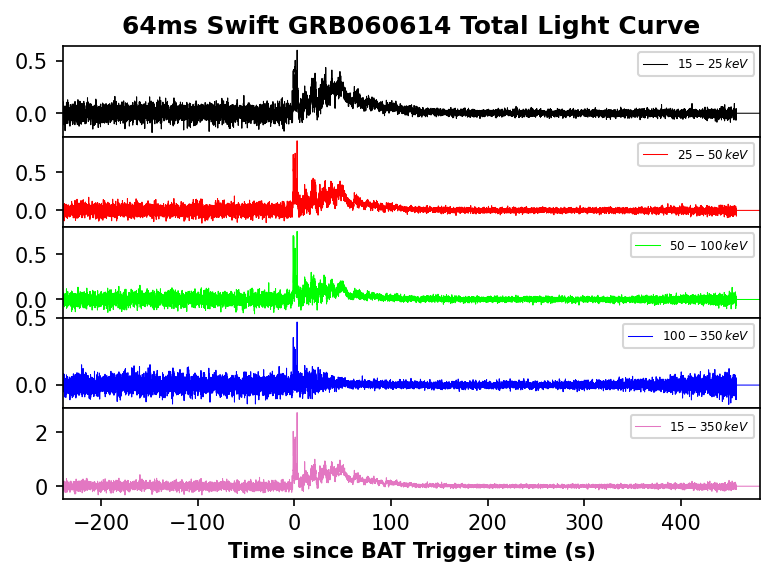

In [ ]:
fig, axes = object1.plot_any_grb(result_GRB[0], t=False)  # Plot all extension of Light Curve

Now, if you need to download hundreds of data files (that is my case), it is faster to do Threading over all names and IDs that loop one by one (e.g. `for` instance), so you can indeed use `so_much_downloads` function:

In [ ]:
if None:
    time1 = time.perf_counter()
    object1.so_much_downloads(GRB_names, ids)
    time2 = time.perf_counter()
    GRB_errors = np.genfromtxt(os.path.join(original_data_path, f"Errors_{object1.res}.txt"), delimiter='|', dtype=str, unpack=True)[0]
    print(f"Downloaded {len(GRB_names)-len(GRB_errors)} light curves in {round(time2-time1, 2)}s (Total = {len(GRB_names)})")

As you saw, this function can take a little time to run, but it is so much faster than loop using `for` instance. Additionally, some GRBs could not be downloaded, you can check them using the `Errors.txt` file, we want to delete this GRBs for the total name list:

In [ ]:
GRB_errors = np.genfromtxt(os.path.join(original_data_path, f"Errors_{object1.res}.txt"), delimiter='|', dtype=str, unpack=True)[0]
print(f'{len(GRB_errors)} GRBs get download error: {GRB_errors}')
GRB_names = list(set(GRB_names) - set(GRB_errors))

22 GRBs get download error: ['GRB170131A' 'GRB160623A' 'GRB160409A' 'GRB150407A' 'GRB140909A'
 'GRB140611A' 'GRB131031A' 'GRB130913A' 'GRB130518A' 'GRB120817B'
 'GRB110604A' 'GRB101204A' 'GRB090827' 'GRB090720A' 'GRB071112C'
 'GRB071028B' 'GRB071010C' 'GRB071006' 'GRB070227' 'GRB070125' 'GRB060123'
 'GRB041219A']


In summary, these errors occur for two reasons:
* First, the GRB doesn't have any Trigger ID
* Second, the GRB has Trigger ID, but it doesn't have any data to download

By this, we close this section by remarking that original size data can use 2.67GB of free space on disk approximately (in decompress mode). But, compressing data using `gzip` library, now:

In [ ]:
size = 0  # Set size variable to zero
for path, dirs, files in os.walk(object1.original_data_path):  # Loop over the folder containing all data downloaded
    for f in files:  # Loop over files into folder
        fp = os.path.join(path, f)  # Join file name with folder path
        size += os.stat(fp).st_size  # Get file size and sum over previous size
print(f"There are {round(size/(1024*1024), 3)} MB of data")

There are 895.909 MB of data


# Swift Data Pre-processing
Now, we want to process the data to prepare it for tSNE implementation. This process consists of 4 phases, following:
* Limit all GRBs out of $T_{100}$
* Normalize light curves (lc) by total fluence in 15-350keV band
* Pad with zeros all GRBs, putting then in the same time standard basis
* Concatenate data from all bands and perform DFT to get Fourier amplitude spectrum

In the next sections, we are going to describe these processes and show how to use some functions to do these steps.

## First step: Limit lc out of $T_{100}$
In this step, we need to extract the durations for all GRBs available in `summary_burst_durations.txt` using the `durations_extractor` instance. If you don't pass any GRB name, this function returns a list containing three values for each GRB in the table: Name, $T_{i}$ start and end times (in seconds), where $i$ can be 50, 90, or 100 (default value), but if you pass it a name, then it returns these values only by this GRB:

In [ ]:
durations_times = object1.names_durations(result_GRB[0])
print(f"{durations_times[0, 0]} has T_100={round(float(durations_times[0, 2])-float(durations_times[0, 1]), 3)}s (T_100 start={durations_times[0, 1]}s, T_100 end={durations_times[0, 2]}s)")

GRB060614 has T_100=180.576s (T_100 start=-1.496s, T_100 end=179.080s)


With these values, we can limit our GRB lc using the instance `lc_limiter`.  In this function, it is possible directly set the time limiters in seconds or pass it an integer to indicate what duration we need (however, these integers can be only 50, 90, and 100). So, we try to extract the lc out of $T_{100}$ by using an integer and setting limits manually, then comparing both:

In [ ]:
limited_data_1 = object1.lc_limiter(result_GRB[0])  # Limiting by T_100
limited_data_2 = object1.lc_limiter(result_GRB[0], limits=(durations_times[0, 1], durations_times[0, 2]))  # By values
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_2)}")
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(limited_data_1[:3], decimals=3))  # Add first 3 rows to each column
x.add_row(['...']*len(column_names))  # Add dots space
x.add_rows(np.round(limited_data_1[-3:-1], decimals=3))  # Add last 2 rows to each column
print(x)

Are both arrays equal? Answer=True
+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
| Time (s) | 15-25keV | Error | 25-50keV | Error | 50-100keV | Error | 100-350keV | Error | 15-350keV | Error |
+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
|  -1.456  |   0.12   | 0.077 |  0.243   |  0.07 |   0.177   | 0.061 |   0.059    | 0.052 |   0.599   | 0.131 |
|  -1.392  |   0.2    | 0.077 |  0.125   | 0.091 |    0.28   |  0.07 |   -0.012   | 0.051 |   0.593   | 0.148 |
|  -1.328  |  0.139   | 0.064 |  0.174   | 0.085 |   0.251   | 0.076 |   0.052    | 0.052 |   0.616   |  0.14 |
|   ...    |   ...    |  ...  |   ...    |  ...  |    ...    |  ...  |    ...     |  ...  |    ...    |  ...  |
| 178.896  |  -0.003  | 0.018 |  0.009   | 0.018 |   0.019   | 0.016 |    0.01    | 0.015 |   0.035   | 0.034 |
|  178.96  |  0.012   | 0.019 |  -0.008  | 0.018 |   -0.027  | 0.015 

Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Graphically, the lc out of $T_{100}$ is:

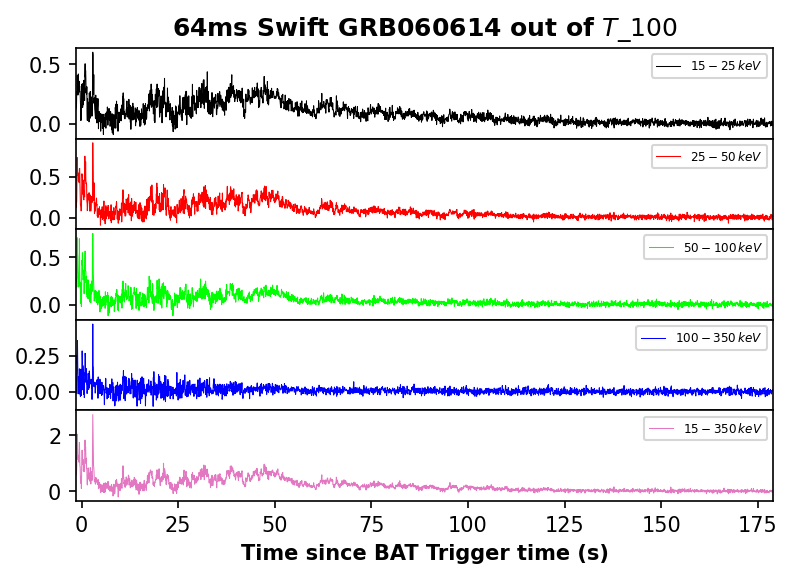

In [ ]:
fig_limited, axes_limited = object1.plot_any_grb(result_GRB[0], t=100)  # Plot Light Curve out of T_100

So, the next step is to do this for all downloaded GRBs, to get a much faster performance of execution, we can use the `so_much_lc_limiters` function:

In [ ]:
y = PrettyTable()  # Create printable table
time1 = time.perf_counter()
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)
time2 = time.perf_counter()
print(f"{len(limited_data)} GRBs limited in {round(time2-time1, 2)}s ({len(errors)} Errors)")
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)

LC Limiting: 100%|██████████| 1367/1367 [02:52<00:00,  7.91GRB/s]


1316 GRBs limited in 173.53s (51 Errors)
+------------+---------+---------+------------+
|    Name    | t_start |  t_end  | Error Type |
+------------+---------+---------+------------+
| GRB080822B |         |         | ValueError |
| GRB170112A |  -0.004 |  0.056  |  Length=1  |
| GRB070810B |  -0.008 |  0.076  |  Length=1  |
| GRB150424A |         |         | IndexError |
| GRB190326A |   0.0   |  0.104  |  Length=1  |
| GRB140311B |         |         | ValueError |
| GRB100206A |  -0.008 |  0.124  |  Length=2  |
| GRB070209  |   0.0   |  0.084  |  Length=2  |
| GRB080315  |         |         | ValueError |
| GRB170906B | -11.776 |  7.424  |  Length=0  |
| GRB130822A |  -0.004 |  0.044  |  Length=0  |
| GRB160525A |         |         | ValueError |
| GRB061218  |         |         | ValueError |
| GRB050509B |   0.0   |  0.028  |  Length=0  |
| GRB041219B |         |         | ValueError |
| GRB150710B |         |         | ValueError |
| GRB081017  |         |         | ValueError |

As you see, the function returns a tuple of limited arrays and errors for all GRBs. In this case, 44 GRBs have any of the following errors:
* _FileNotFoundError_ if GRB does not have any data file downloaded in the selected resolution.
* _ValueError_ if the code can't get any limit values.
* _IndexError_ if the GRB does not appear in the `summary_burst_durations` table.
* _Length={value}_ if the limited GRB data has less than three discrete points.
* _Only zeros_ if the limited GRB data only has zeros.

Additionally, the second argument returned by `so_much_lc_limiters` is a GRB names array indicating the order of results (the first argument returned). This order is now our `GRB_names` variable because it does not have the error names.

To check if the `so_much_lc_limiters` instance is doing its job well, we are going to compare (for the random GRB selected before) if the data stored in _limited_data_1_ and obtained in parallelizing are equal:

In [ ]:
random_index = GRB_names.index(result_GRB[0])  # Search random GRB in new GRB names list
limited_data_random_GRB = np.array(limited_data[random_index])  # Extract limited values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_random_GRB)}")

Are both arrays equal? Answer=True


## Second step: Normalizing Light Curves
GRBs have one fact that is widely known: long GRBs typically but not always has higher fluence. To avoid t-SNE being distracted by this fact, we need to normalize our lc by total time-integrated flux, `lc_normalizer` instance does this job by using the Simpson's Rule in any array. This function returns a tuple normalized data, total time-integrated flux if _print_area_ parameter is _True_, otherwise only returns normalized data:

In [ ]:
normalized_data_random_GRB, total_flux = object1.lc_normalizer(limited_data_random_GRB, print_area=True)
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(normalized_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(normalized_data_random_GRB[np.r_[-2:0]], decimals=4))  # Add new rows of limited data
print(f"Total time-integrated flux for {result_GRB[0]} is: {round(total_flux, 4)}")
print(x)

Total time-integrated flux for GRB060614 is: 38.6704
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
| Time (s) | 15-25keV | Error  | 25-50keV | Error  | 50-100keV | Error  | 100-350keV | Error  | 15-350keV | Error  |
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
|  -1.456  |  0.0031  | 0.002  |  0.0063  | 0.0018 |   0.0046  | 0.0016 |   0.0015   | 0.0013 |   0.0155  | 0.0034 |
|  -1.392  |  0.0052  | 0.002  |  0.0032  | 0.0024 |   0.0072  | 0.0018 |  -0.0003   | 0.0013 |   0.0153  | 0.0038 |
|   ...    |   ...    |  ...   |   ...    |  ...   |    ...    |  ...   |    ...     |  ...   |    ...    |  ...   |
|  178.96  |  0.0003  | 0.0005 | -0.0002  | 0.0005 |  -0.0007  | 0.0004 |   0.0004   | 0.0004 |  -0.0002  | 0.0009 |
| 179.024  | -0.0002  | 0.0005 | -0.0002  | 0.0005 |   0.0002  | 0.0004 |  -0.0001   | 0.0004 |  -0.0002  | 0.0009 |
+----------

Note that normalized data are only limited data divided by 15-350keV integrated flux. So, the next step is to do this for all limited GRBs, to get a much faster performance of execution, we can use the `so_much_normalize` function. To check if this instance is doing its job well, we are going to compare (for the random GRB selected before) if the data stored in _normalized_data_random_GRB_ and obtained in parallelizing are equal:

In [ ]:
normalized_data = object1.so_much_normalize(limited_data)  # Normalizing all light curves
normalized_data_random_GRB_2 = normalized_data[random_index]  # Extract normalized values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(normalized_data_random_GRB, normalized_data_random_GRB_2)}")

LC Normalizing: 100%|██████████| 1316/1316 [00:05<00:00, 255.28GRB/s]


Are both arrays equal? Answer=True


## Third step: Zero Padding
With all GRBs limited out of $T_{100}$ and normalized, we need now to zero-pad their light curves to place them on the same time basis. The `zero_pad` instance performs this job by checking the max length of a data set and looking for the best suitable array size to do Fast Fourier Transform (FFT, the next step in data pre-processing).

Here, we are going to see how this function zero pad the data at its end for the random selected GRB before:

In [ ]:
zero_padded_data = object1.so_much_zero_pad(normalized_data)
zero_padded_data_random_GRB = zero_padded_data[random_index]
print(f"Best FFT suitable data length: {len(zero_padded_data_random_GRB)}")
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(zero_padded_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[len(normalized_data_random_GRB)-2:len(normalized_data_random_GRB)+2], decimals=4))  # Add new end rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[-3:-1], decimals=4))  # Add new end rows of limited data
print(x)

LC Zero-Padding: 100%|██████████| 1316/1316 [00:09<00:00, 144.25GRB/s]


Best FFT suitable data length: 15309
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
| Time (s) | 15-25keV | Error  | 25-50keV | Error  | 50-100keV | Error  | 100-350keV | Error  | 15-350keV | Error  |
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
|  -1.456  |  0.0031  | 0.002  |  0.0063  | 0.0018 |   0.0046  | 0.0016 |   0.0015   | 0.0013 |   0.0155  | 0.0034 |
|  -1.392  |  0.0052  | 0.002  |  0.0032  | 0.0024 |   0.0072  | 0.0018 |  -0.0003   | 0.0013 |   0.0153  | 0.0038 |
|   ...    |   ...    |  ...   |   ...    |  ...   |    ...    |  ...   |    ...     |  ...   |    ...    |  ...   |
|  178.96  |  0.0003  | 0.0005 | -0.0002  | 0.0005 |  -0.0007  | 0.0004 |   0.0004   | 0.0004 |  -0.0002  | 0.0009 |
| 179.024  | -0.0002  | 0.0005 | -0.0002  | 0.0005 |   0.0002  | 0.0004 |  -0.0001   | 0.0004 |  -0.0002  | 0.0009 |
| 179.088  |   0.0    |  0.

## Final Step: Discrete Fourier Transform
Finally, the last step of Swift data pre-processing is to perform a Fast Fourier Transform to zero-padded normalized data out of $T_{100}$. There are so many python packages to do this job, particularly in this notebook, we are going to use _scipy_ in the `fourier_concatenate` instance, but before that, this function concatenate all energy band measurements in one single array, as required to execute DFT:

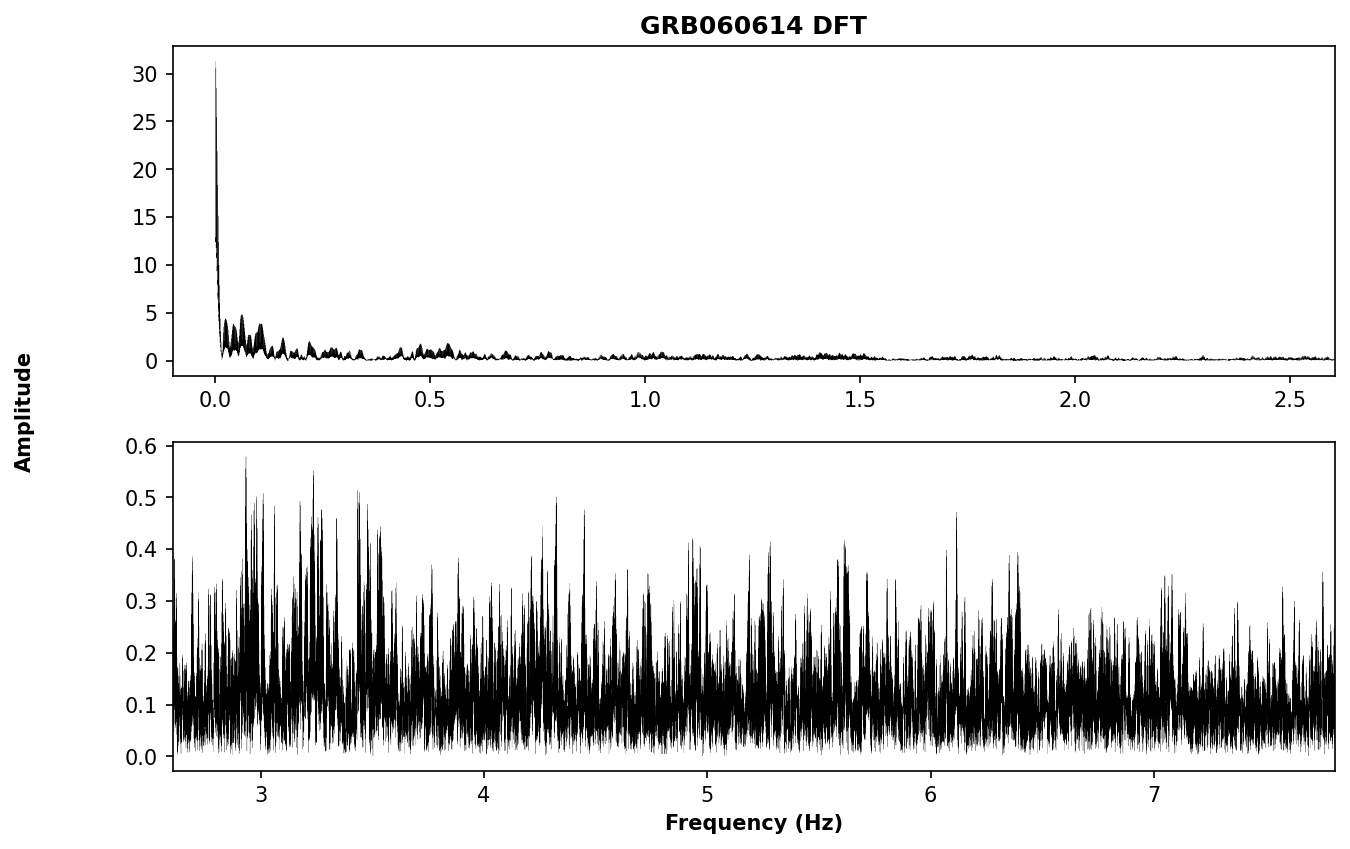

In [ ]:
dft_random_GRB, dft_fig = object1.fourier_concatenate(zero_padded_data[random_index], plot=True, name=result_GRB[0])

Note that DFT data is below the Nyquist frequency, following the Nyquist-Shannon sampling theorem:

_The Nyquist-Shannon sampling theorem states that a signal sampled at a rate can be fully reconstructed if it contains only frequency components below half that sampling frequency. Thus the highest frequency output from the DFT is half the sampling rate._

With this, we can now calculate DFT for the entire zero-padded dataset using the `so_much_fourier` instance:

In [ ]:
pre_processing_data = object1.so_much_fourier(zero_padded_data)

Performing DFT: 100%|██████████| 1316/1316 [00:14<00:00, 92.27GRB/s] 


Finally, the pre-processing data stage is over. Then, we want to save all data in a compressed format to load in the next section. For this, you can use the `save_data` function (based in `savez_compressed` instance of Numpy):

In [ ]:
object1.save_data(f"DFT_Preprocessed_data_{object1.res}ms", names=GRB_names, data=pre_processing_data)

# t-SNE in Swift Data
t-Distributed Stochastic Neighbor Embedding (or t-SNE) is a popular non-linear dimensionality reduction technique used for visualizing high dimensional data sets. After pre-processing Swift data in the $x_i$ vectors with Fourier Amplitudes, we want to perform this method by taking so much care when we read the results. Why? The t-SNE algorithm doesn’t always produce similar output on successive runs, and it depends on some hyperparameters related to the optimization process.

In this study, the most relevant hyperparameters on the cost function are (following the scikit-Learn and open-TSNE packages documentation):
* __Perplexity__: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Note that perplexity linearly impacts runtime i.e. higher values of perplexity will incur longer execution time.
* __learning_rate__: The learning rate controls the step size of the gradient updates. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers.
* __metric__: The metric to use when calculating distance between instances in a feature array.

## t-SNE convergency
First of all, we want to see how t-SNE converges in the pre-processed data. To do this, we use the [tsne_animate](https://github.com/sophronesis/tsne_animate) package from GitHub in the `tsne_animation` function. But, before we need to load the pre-processing data saved:

In [3]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.res}ms.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
print(f"There are {len(GRB_names)} GRBs loaded: {GRB_names}")

There are 1316 GRBs loaded: ['GRB050724' 'GRB200528A' 'GRB110719A' ... 'GRB080804' 'GRB111212A'
 'GRB200410A']


Now, we check for the $T_{90}$ value for each GRB and separate them into short and long if it has $T_{90} < 2$. Then we set the standard _perplexity_ value (30) from Jespersen, set auto _learning rate_ in scikit-Learn t-SNE implementation, and perform the animation:

In [4]:
durations_data_array = np.array([object1.names_durations(name, t=90) for name in GRB_names])  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = end_times - start_times  # T_90 is equal to t_end - t_start
tsne_animated = object1.tsne_animation(features, durations)

In [5]:
output = os.system('jupyter nbconvert  README.ipynb --to markdown --output README.md')
output2 = os.system('jupyter nbconvert  README.ipynb --to html --output README.html')
print(f"Readable file created") if output == 0 else None

Readable file created
